# BSPF Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['path_to_figs'] = data_path+"BSPF/figures/"

config['catalog'] = ""

config['save'] = False

## Load Data

In [5]:
data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")


## Modify Data

Filter data

In [6]:
## reject nan values
print(f" AMAX:  all: {data_amax_disp.origin.size} no_nan: {data_amax_disp.dropna().shape[0]}")
data_amax_disp.dropna(inplace=True)

print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.dropna().shape[0]}")
data_snr.dropna(inplace=True)

 AMAX:  all: 282 no_nan: 180
 SNR:  all: 282 no_nan: 278


In [7]:
## reject all magnitude types not ml
nn = [mm for mm in data_amax_disp.Mag_type if mm != "ml"]

data_amax_disp = data_amax_disp[data_amax_disp.Mag_type == "ml"]
data_snr = data_snr[data_snr.Mag_type == "ml"]

print(f"\n -> rejected {len(nn)} events: {nn}")


 -> rejected 6 events: ['mlr', 'mw', 'mw', 'mw', 'mw', 'mlr']


In [8]:
data_amax_disp_cosum_6 = data_amax_disp[data_amax_disp.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]


In [9]:
data_snr_cosum_6.shape, data_amax_disp_cosum_6.shape

((143, 24), (89, 24))

## Plots

In [10]:
def __makeplot(data1, data2, data3, data4):

    import matplotlib

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    font=14

    cmap = plt.get_cmap("viridis", 9)

    # dat = np.log10(data4.BSPF__N_snr)
    dat = np.log10(data4.PFO_10_Z_snr)


    ax.scatter(data1.Hdistance_km, data1.Magnitude, s=30, color="grey", zorder=1, label=f"all (N={len(data1)})")

    cax = ax.scatter(data2.Hdistance_km, data2.Magnitude, s=50, lw=0.5, edgecolors="k",
                     c=dat, cmap=cmap, zorder=2, label=f"CoSum6 (N={len(data2)})", vmin=round(min(dat),1), vmax=4.5)

    ax.grid(ls="--", color="grey", alpha=0.6, zorder=0,which="both")
    ax.legend(loc=4, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocenter Distance (km)", fontsize=font)

    ax.set_xscale("log")
    ax.set_xlim(left=10)

    cbar = plt.colorbar(cax, pad=0.02)
    cbar.set_label(r"log$_{10}$(signal-to-noise ratio)", fontsize=font)
#     cbar.set_clim(0,4)

    ax.set_xticks([10, 20, 30, 40, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()

# __makeplot(data_amax_disp, data_amax_disp_cosum_6, data_snr, data_snr_cosum_6)

## Magnitude Scale 

$M_L = log_{10} (A_{max}) + 1.11 log_{10} (R) + 0.00189 R - 2.09$   (adopted local magnitude scale)

with $R$ = hypocentral distance in km and $A_{max}$ = maximal amplitude in nm

In [11]:
def __ml(amax, hdist):
    return np.log10(amax) + 1.11*np.log10(hdist) + 0.00189*hdist -2.09

In [12]:

## reject nan values
print(f" AMAX:  all: {data_amax_disp.origin.size} no_nan: {data_amax_disp.dropna().shape[0]}")
data_amax_disp.dropna(inplace=True)

## reject all magnitude types not ml
nn = [mm for mm in data_amax_disp.Mag_type if mm != "ml"]
data_amax_disp = data_amax_disp[data_amax_disp.Mag_type == "ml"]
print(f"\n -> rejected {len(nn)} events: {nn}")

 AMAX:  all: 174 no_nan: 174

 -> rejected 0 events: []


In [13]:
mm_z = __ml(data_amax_disp.PFO_10_Z_amax*1e6, data_amax_disp.Hdistance_km)
mm_n = __ml(data_amax_disp.PFO_10_N_amax*1e6, data_amax_disp.Hdistance_km)
mm_e = __ml(data_amax_disp.PFO_10_E_amax*1e6, data_amax_disp.Hdistance_km)

mm_t = __ml(data_amax_disp.PFO_10_T_amax*1e6, data_amax_disp.Hdistance_km)
mm_r = __ml(data_amax_disp.PFO_10_R_amax*1e6, data_amax_disp.Hdistance_km)


In [14]:
def __makeplot_magnitude_comparison():

    fig, ax = plt.subplots(1,3, figsize=(15,4))

    ax[0].scatter(hdist, mm, color='k', zorder=3)
    ax[0].scatter(hdist, mm_z, s=15, zorder=3, label="Z", edgecolors="tab:orange", color="tab:orange", alpha=0.7)
    ax[0].scatter(hdist, mm_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0].scatter(hdist, mm_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0].grid(zorder=0, alpha=0.4)
    ax[0].legend(loc=4)

    ax[0].set_xlabel(r"log$_{10}$( Hypocentral Distance ) (km)")
    ax[0].set_ylabel("Magnitude")

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mm, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1].hist(mm, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1].hist(mm_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1].hist(mm_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.5, fill=False, align="mid", label="N")
    ax[1].hist(mm_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.3, fill=False, align="mid", label="E")
    ax[1].set_xticks(bars)
    # ax[1].set_xticks(bars+dbars/2)
    # ax[1].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1].legend(loc=1)
    ax[1].grid(zorder=0, alpha=0.4)

    ax[1].set_xlabel(r"M$_L$")
    ax[1].set_ylabel("Total Number")

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[2].hist(diff_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[2].hist(diff_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[2].legend(loc=1)
    ax[2].grid(zorder=0, alpha=0.4)

    ax[2].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[2].set_ylabel("Total Number")

    plt.show();

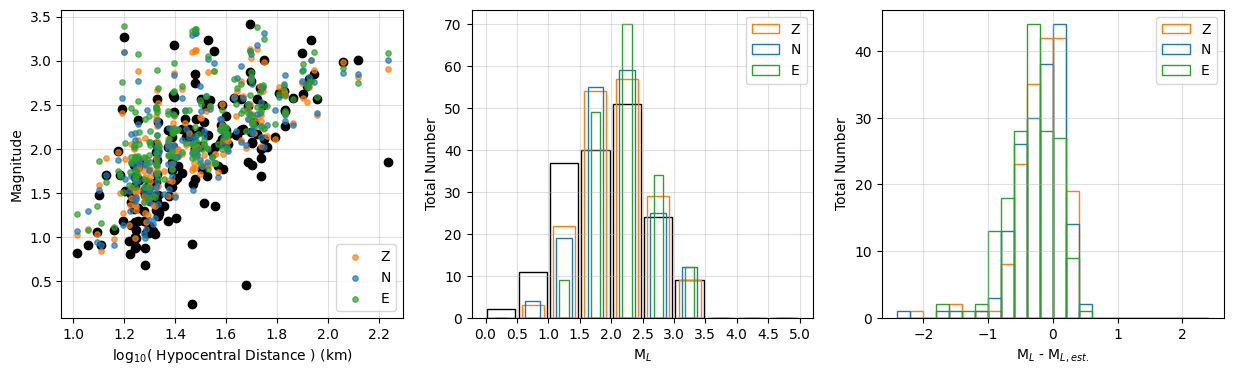

In [15]:
x_events = range(len(data_amax_disp))

hdist = np.log10(data_amax_disp.Hdistance_km)

mm = data_amax_disp.Magnitude

diff_z, diff_n, diff_e = mm-mm_z, mm-mm_n, mm-mm_e

__makeplot_magnitude_comparison()

## Fitting Translation Data

In [16]:
def __ml_fit(X, a, b ,c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b*hdist - c

In [17]:
def __predict_local_amplitude_ml(X):
    mag, hdist = X
    return 10**( mag - 1.11*np.log10(hdist) - 0.00189*hdist +  2.09)

In [18]:
def __predict_local_amplitude(X, a, b ,c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist + c )

In [19]:
## select amplitude data
amax_n = data_amax_disp_cosum_6.PFO_10_N_amax*1e9
amax_e = data_amax_disp_cosum_6.PFO_10_E_amax*1e9

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
mag = data_amax_disp_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_trans:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_trans:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e

## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])


 N_trans:   Ml = log10(Amax) + 1.23 log10(R) + 0.00480 R + 5.56

 E_trans:   Ml = log10(Amax) + 1.67 log10(R) + 0.00420 R + 6.32


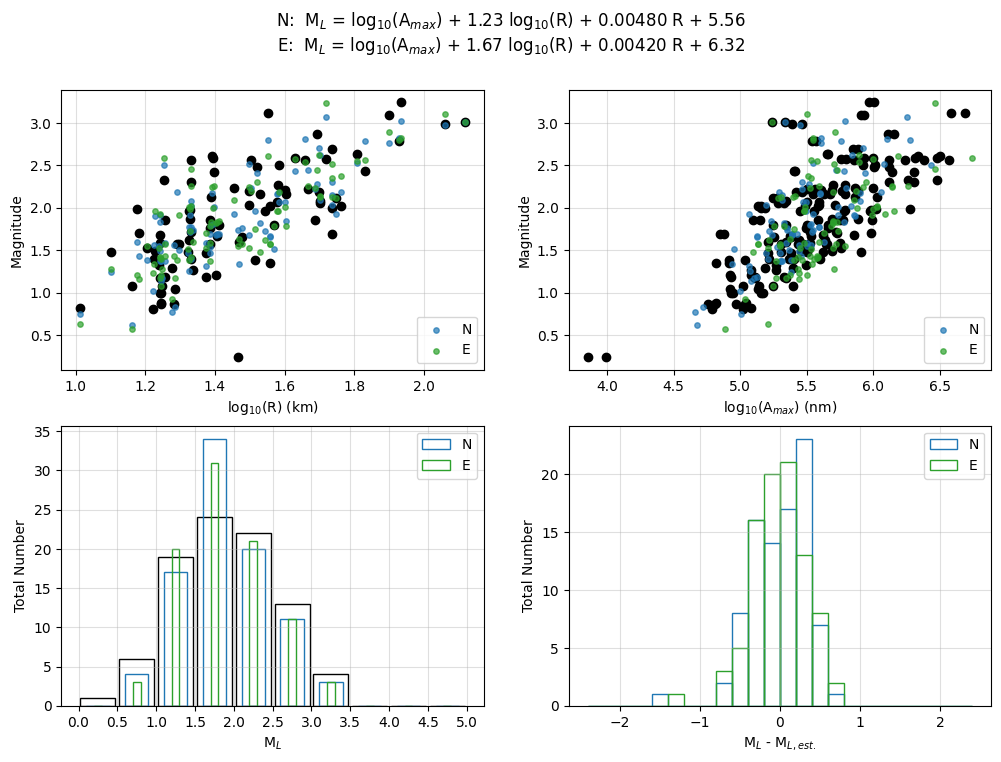

In [20]:
def __makeplot_magnitude_comparison2():

    fig, ax = plt.subplots(2,2, figsize=(12,8))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$(R) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$(A$_{max}$) (nm)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,1].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________


    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    # ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")



    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison2()

# fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_translationsNE.png", format="png", dpi=200, bbox_inches='tight')

## Fitting Rotation Data

In [21]:
## select amplitude data
amax_n = data_amax_disp_cosum_6.BSPF__N_amax
amax_e = data_amax_disp_cosum_6.BSPF__E_amax

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
mag = data_amax_disp_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_rot:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_rot:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e


## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])


 N_rot:   Ml = log10(Amax) + 2.08 log10(R) + 0.00175 R + -4.70

 E_rot:   Ml = log10(Amax) + 1.74 log10(R) + 0.00283 R + -5.39


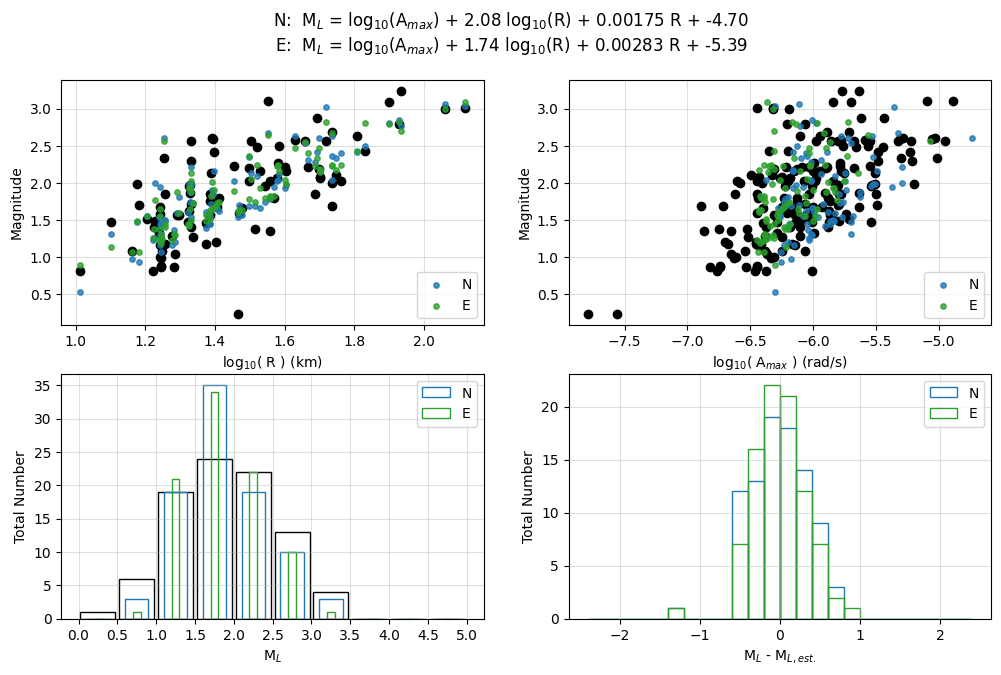

In [22]:
def __makeplot_magnitude_comparison3():

    fig, ax = plt.subplots(2,2, figsize=(12,7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, zorder=3, color="black")
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,0].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)
    # ax[1,0].set_xticks(bars+dbars/2)
    # ax[1,0].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    # ax[1,1].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")


    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison3()

# fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_rotationsNE.png", format="png", dpi=200, bbox_inches='tight')

## Test 

In [23]:
## select amplitude data
amax = data_amax_disp_cosum_6.BSPF__N_amax
amax = np.append(amax, data_amax_disp_cosum_6.BSPF__E_amax)

## select hypocentral distances and magnitudes
hdist = data_amax_disp_cosum_6.Hdistance_km
hdist = np.append(hdist, data_amax_disp_cosum_6.Hdistance_km)

mag = data_amax_disp_cosum_6.Magnitude
mag = np.append(mag, data_amax_disp_cosum_6.Magnitude)

## perform data fitting
popt, pcov = curve_fit(__ml_fit, (amax, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n rot:   Ml = log10(Amax) + {popt[0]:.2f} log10(R) + {popt[1]:.5f} R + {popt[2]:.2f}")

## generate synthetic magnitudes
syn_data = __ml_fit((amax, hdist), popt[0], popt[1], popt[2])

## compute differences of magnitudes and synthetics
diff_syn = mag-syn_data

## compute synthetic maximal amplitudes
# amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn = __predict_local_amplitude((mag, hdist), popt[0], popt[1], popt[2])



 rot:   Ml = log10(Amax) + 1.91 log10(R) + 0.00229 R + -5.05


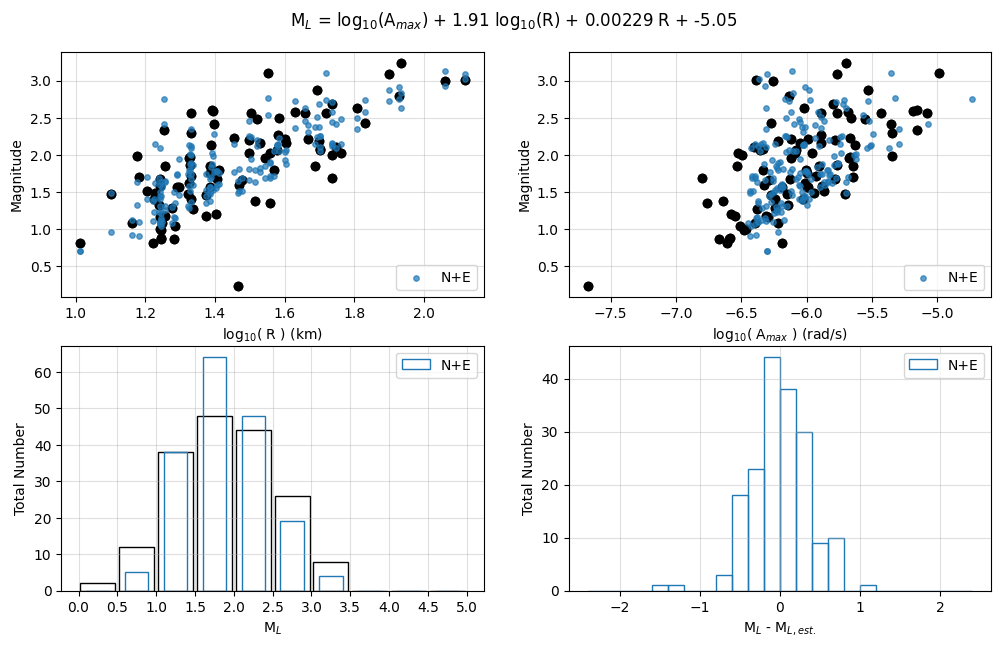

In [24]:
def __makeplot_magnitude_comparison4():

    fig, ax = plt.subplots(2,2, figsize=(12,7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")

    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")

    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")

    ax[1,0].hist(syn_data, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N+E")

    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    ax[1,1].hist(diff_syn, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N+E")


    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")

    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    plt.suptitle(f" {ml_str} = {log10_str}({amax_str}) + {popt[0]:.2f} {log10_str}(R) + {popt[1]:.5f} R + {popt[2]:.2f}", y=0.94)

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison4()

# fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_modelallrotations.png", format="png", dpi=200, bbox_inches='tight')

## Minimal Amplitude

In [25]:
def __predict_local_magnitude(X, a, b ,c):
    amp, hdist = X
    return np.log10(amp) + a*np.log10(hdist) + b*hdist - c

In [26]:
min_amp_rot = 10e-7  # rad/s

a, b, c = 1.91, 0.00229, -5.05

hdist = np.arange(1, 200, 1)
mag = np.arange(0, 6.0, 0.1)

amax_syn = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn[i,j] = __predict_local_amplitude((m, h), a, b, c)


In [27]:
bspf_e = data_amax_disp_cosum_6.BSPF__E_amax
bspf_n = data_amax_disp_cosum_6.BSPF__N_amax

bspf_mag = data_amax_disp_cosum_6.Magnitude
bspf_hdist = data_amax_disp_cosum_6.Hdistance_km

limit = 1e-7  ## rad/s
mag_limit = __predict_local_magnitude((limit, hdist), popt_n[0], popt_n[1], popt_n[2])

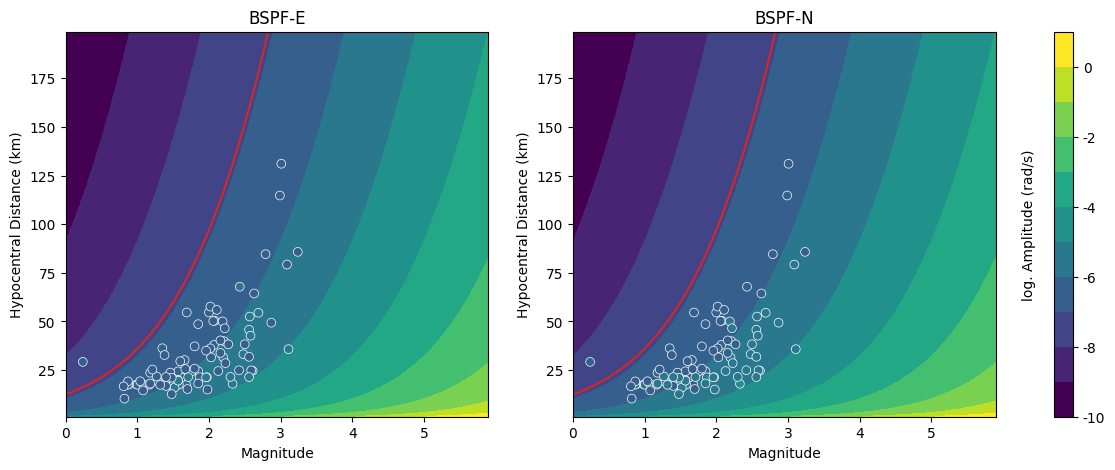

In [28]:
def __makeplot():

    fig, ax = plt.subplots(1,2, figsize=(15,5))

    import matplotlib as mpl
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    cmap = mpl.colormaps['viridis'].resampled(11)

    amin, amax = min(amax_syn.reshape(1, amax_syn.size)[0]), max(amax_syn.reshape(1, amax_syn.size)[0])

    lev = np.logspace(round(np.log10(amin),0),round(np.log10(amax),0), 10)
    lev = np.logspace(-10,1, 12)
    lev_lbl = np.linspace(-10, 1, 12).astype(int)

    ax[0].scatter(bspf_mag, bspf_hdist, c=bspf_e, s=40, cmap=cmap, edgecolors="white", lw=0.5, zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    cb0 = ax[0].contourf(mag, hdist, amax_syn, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb1 = ax[1].scatter(bspf_mag, bspf_hdist, c=bspf_n, s=40, cmap=cmap, edgecolors="white", lw=0.5, zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    ax[1].contourf(mag, hdist, amax_syn, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)

    ax[0].plot(mag_limit, hdist, color="tab:red")
    ax[1].plot(mag_limit, hdist, color="tab:red")

    ax[0].set_xlim(left=0)
    ax[1].set_xlim(left=0)

    cbar0 = plt.colorbar(cb0, ax=ax)
    cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label("log. Amplitude (rad/s)", labelpad=-60)

    ax[0].set_xlabel("Magnitude")
    ax[0].set_ylabel("Hypocentral Distance (km)")

    ax[1].set_xlabel("Magnitude")
    ax[1].set_ylabel("Hypocentral Distance (km)")

    ax[0].set_title("BSPF-E")
    ax[1].set_title("BSPF-N")

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+"BSPF_model_magnitudescale.png", format="png", dpi=200, bbox_inches='tight')

## Polar Plot

In [57]:
def __polar_plot(data1, data2, data0):

    r2 = data2.Edistance_km
    theta2 = np.radians(data2.BAZ)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)


    r1 = data0.edist_km
    theta0 = np.radians(data0.baz_theo)
    ax.scatter(theta0, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2, alpha=0.2)


    ax.scatter(theta2, r2, s=5**data2.Magnitude, c=data2.BSPF__E_amax ,lw=0.5, edgecolors="k", zorder=3)

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

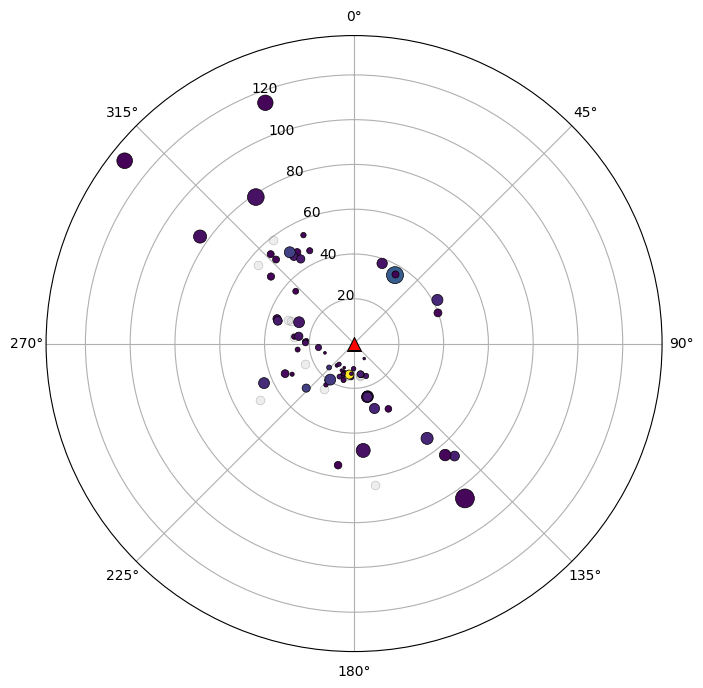

In [58]:
__polar_plot(data_amax_disp_cosum_6, data_amax_disp_cosum_6, data_baz)

In [31]:
data_baz = pd.read_pickle(config['path_to_data']+"bspf_baz_estimates.pkl")
data_baz_adr = pd.read_pickle(config['path_to_data']+"iadr_baz_estimates.pkl")

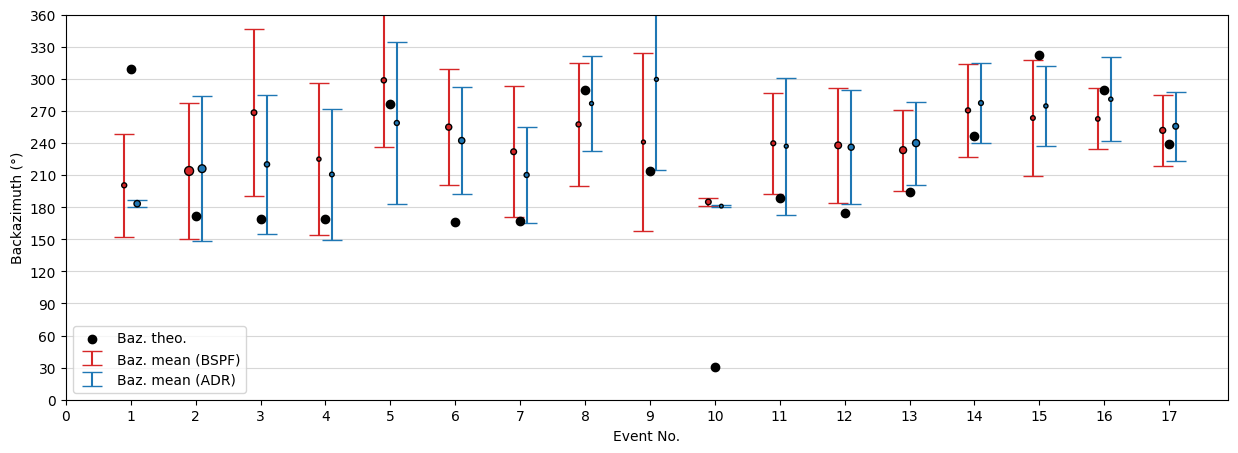

In [35]:
x = np.arange(1,len(data_baz.event_time)+1)

plt.figure(figsize=(15,5))
plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")

plt.scatter(x-0.1, data_baz.baz_mean, s=data_baz.samples+5, c="tab:red", zorder=3, edgecolors="k")
plt.errorbar(x-0.1, data_baz.baz_mean, yerr=data_baz.baz_std, ms=0, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean (BSPF)")

plt.scatter(x+0.1, data_baz_adr.baz_mean, s=data_baz_adr.samples+5, c="tab:blue", zorder=3, edgecolors="k")
plt.errorbar(x+0.1, data_baz_adr.baz_mean, yerr=data_baz_adr.baz_std, ms=0, capsize=7, fmt="o", c="tab:blue", zorder=2, label="Baz. mean (ADR)")

plt.xticks(np.arange(0,18))
plt.yticks(np.arange(0,390,30))
plt.ylim(0, 360)

plt.xlabel("Event No.")
plt.ylabel("Backazimuth (°)")
plt.legend(loc=3)
plt.grid(alpha=0.5, zorder=-1, axis="y")

plt.show();

fig.savefig(config['path_to_figs']+"backazimuth_for_BSPF_and_ADR.png", format="png", dpi=200, bbox_inches='tight');

In [36]:
def __polar_plot2(data1):

    r1 = data1.edist_km

    theta1 = np.radians(data1.baz_mean)
    theta2 = np.radians(data1.baz_theo)

    err = data1.baz_std

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    m1 = ax.scatter(theta1, r1, s=40, c="tab:red", marker="o", lw=0.5, edgecolors="k", zorder=3)
    m1.set_facecolor('none')

    ax.scatter(theta2, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2)

    for i in range(len(r1)):
        ax.plot([theta1[i], theta2[i]], [r1[i], r1[i]], c="k", zorder=1, alpha=0.5, ls=":")

    # ax.bar(theta1, r1, width=err/200, bottom=0.0, color="b", alpha=0.5)
    ax.errorbar(theta1, r1, xerr=err/100, yerr=None, capsize=7, fmt="o", c="tab:red")

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

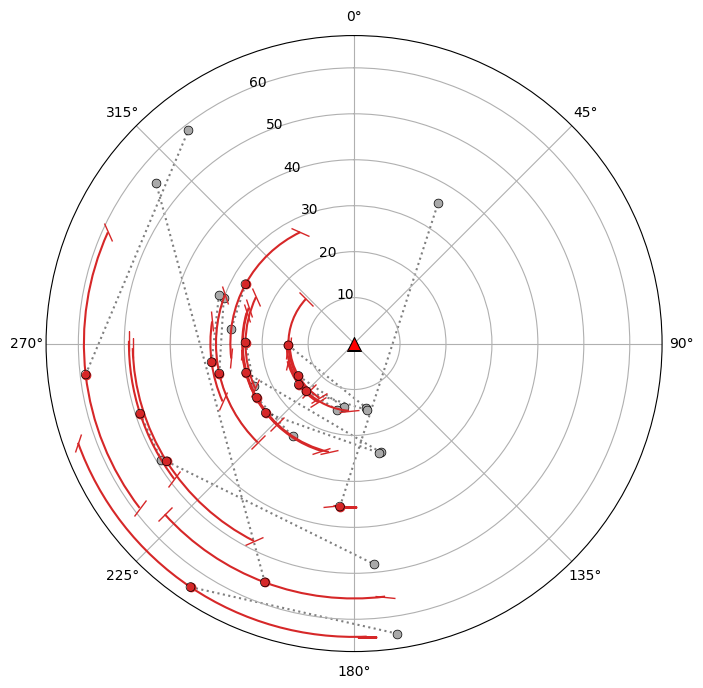

In [37]:
__polar_plot2(data_baz)

In [38]:
data_baz

,event_time,event_num,baz_mean,baz_median,cc_thres,baz_theo,baz_std,percentile_05,percentile_90,samples,edist_km
0,2022-10-03 16:08:09.970,1,200.485441,182.511246,0.4,309.024563,47.967789,[180.52069842932468],[227.7476016250846],8,55.472148
1,2022-10-07 22:45:05.470,1,213.886543,184.811086,0.4,171.520189,63.455906,[180.63340715325592],[356.15679213568023],36,63.835594
2,2022-10-15 05:17:34.150,1,268.423111,330.553131,0.4,169.085145,78.139180,[180.45766101451184],[349.9117441335535],11,14.286083
3,2022-10-23 09:24:58.150,1,224.968368,185.687836,0.4,169.312421,71.077353,[181.1257419969194],[299.58957422072103],4,14.670320
4,2022-10-26 08:14:35.080,1,298.660739,328.940661,0.4,276.630840,62.127182,[183.36949589616603],[340.1725794544982],9,26.920215
5,2022-12-31 12:12:26.650,1,254.875637,252.076186,0.4,166.264929,54.273011,[187.229558411269],[326.647551091912],14,24.334570
6,2023-01-09 19:42:56.460,1,231.882628,200.434838,0.4,167.064154,61.017752,[187.4799740571401],[327.38749081278195],12,24.425123
7,2023-01-11 18:59:20.030,1,257.465053,254.216347,0.4,289.306150,57.807362,[188.40767092578318],[325.54651245453954],8,30.048739
8,2023-01-15 09:58:54.070,1,240.939676,182.010772,0.4,213.587559,83.497629,[181.80773270347444],[323.62062174686133],3,24.217721
9,2023-02-01 09:05:02.320,1,184.947123,183.624463,0.4,30.887144,4.011633,[181.25715851175949],[190.68109223061293],11,35.609655
